In [1]:
pd.set_option('display.max_colwidth', 100)
from copy import deepcopy
from scipy.stats.mstats import mquantiles
from chase.cpt import *
from chase.drift import *
from chase.base import *
from chase.utils import *
from chase.fit import *
from mypy.explib.technion import technion
import itertools
from scipy.stats import pearsonr

def pmatch(pair):
    observed, predicted = pair
    
    if observed == 0.5 or predicted == 0.5:
        return 0.5
    elif (observed < 0.5 and predicted < 0.5) or (observed > 0.5 and predicted > 0.5):
        return 1
    else:
        return 0

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'
TABDEST = '/Users/markant/code/chase/chase/paper/results_tables'
OUTDIR = 'results_fits/chase_fitresults_tpt'


# number of iterations for each parameter set
N_ITER = 2

# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 2],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'sc': [0, 5, 1],
        'p_stop': [0, 1, .5],
        'k': [0, 5, 1],
        'sep': [0, 10, 1]}

PARSETS = {}
PARSETS['optional'] = [['theta', 'tau', 'k', 'sep'],
                       ['theta', 'tau', 'k', 'sep', 'prelec_gamma'],
                       #['theta', 'p_stay', 'tau', 'sc', 'prelec_gamma'],
                       #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                       #['theta', 'p_stay', 'tau', 'sc', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [#['p_stop', 'p_stay', 'tau', 'sc'],
                        #['p_stop', 'p_stay', 'tau', 'sc', 'prelec_gamma'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                        #['p_stop', 'p_stay', 'tau', 'sc', 'pow_gain'],
                        #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                        ]

FIXED = {}
for pref_units in ['sums', 'diffs']:
    FIXED[('optional',pref_units)] = {'p_sample_H': 0.5,
                                      'minsamplesize': 2,
                                      'pref_units': pref_units,
                                      'stoprule': 'optional'}

    FIXED[('geometric',pref_units)] = {'p_sample_H': 0.5,
                                       'minsamplesize': 2,
                                       'pref_units': pref_units,
                                       'stoprule': 'geometric',
                                       'theta': 30}
    
cp = {}
bf_cp = {}
bf_par = {}
msd_cp = {}
quant = {}
bf_quant = {}

cp_asc = {}
bf_cp_asc = {}

In [4]:
m = CHASEModel(drift='cpt',
               startdist='laplace',
               problems=problems)
pars = {'theta': 2,
        'p_stay': 0.3,
        'tau': 1,
        'prelec_gamma': 1.4,
        'pref_units': 'diffs',
        'minsamplesize': 2,
        'sc': 1,
        'p_sample_H': .5}

drifts = [m.drift(problems[pid], pars) for pid in problems_srt]

/Users/markant/code/chase/chase/cpt.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  lossdf = pd.DataFrame(np.array(losses), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/code/chase/chase/cpt.py:59: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  gaindf = pd.DataFrame(np.array(gains), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/code/chase/chase/cpt.py:71: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'gaindf' in option:
/Users/markant/code/chase/chase/cpt.py:29: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))
/Users/markant/code/chase/chase/cpt.py:96: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  weights[gaindf.iloc[i]['id']] = gaindf.iloc[i]['w']


In [4]:
m = CHASEModel(drift='cpt',
               startdist='laplace',
               problems=problems)
pars = {'theta': 2,
        'p_stay': 0.3,
        'tau': 1,
        'prelec_gamma': 1.4,
        'pref_units': 'sums',
        'minsamplesize': 2,
        'sc': 1,
        'p_sample_H': .5}

drifts_sums = [m.drift(problems[pid], pars) for pid in problems_srt]

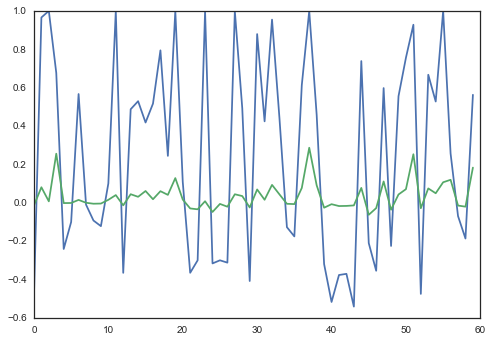

In [5]:
plt.plot(drifts)
plt.plot(drifts_sums)

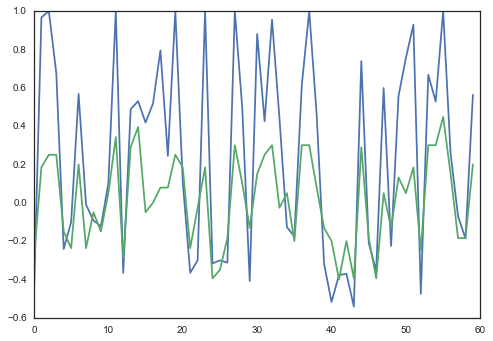

In [6]:
cp = np.array([data[data.problem==i].choice.mean() for i in problems_srt])
plt.plot(drifts)
plt.plot(cp - .5)

# Load data for estimation set

In [2]:
technion.load_data('est')
problems = {(gid-1): technion.get_options(gid) for gid in technion.problems}
problems_srt = technion.problems_srt - 1

data = pd.read_csv('data/tpt/tpt_data_est.csv', index_col=0)
data['group'] = 0

SIM_ID = 'tpt_est'

# Fit estimation set

In [3]:
#for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
for stoprule, pref_units in itertools.product(['optional'], ['diffs']):    
    
    print '[%s, %s]\nsaving results to %s' % (stoprule, pref_units, OUTDIR)
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
    
    if stoprule == 'optional':      model = CHASEModel
    elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
        
    for parset in P:

        fitting = {p: PARS[p] for p in parset}

        m = model(drift='cpt',
                  startdist='laplace',
                  problems=problems,
                  stoprule=stoprule)

        # fit
        results = fit_mlh(m, problems, data, SIM_ID, F, fitting, 
                          niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

[optional, diffs]
saving results to results_fits/chase_fitresults_tpt
tpt_est(k,sep,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=optional)
0/4
['theta']: [ 1.]
iteration           0
success          True
nllh          4721.35
k            0.313619
N                1170
bic           9470.96
theta               1
k            0.313619
sep                10
tau               NaN
Name: 0, dtype: object
tpt_est(k,sep,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=optional)
1/4
['theta']: [ 2.]
iteration           0
success          True
nllh          4640.02
k            0.167603
N                1170
bic           9308.29
theta               2
k            0.167603
sep           9.97723
tau          0.999996
Name: 1, dtype: object
tpt_est(k,sep,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=optional)
2/4
['theta']: [ 1.]
iteration           1
success          True
nllh          4721.35
k            0.313756
N                117

/Users/markant/code/chase/chase/cpt.py:66: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  lossdf = pd.DataFrame(np.array(losses), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/code/chase/chase/cpt.py:64: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  gaindf = pd.DataFrame(np.array(gains), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/markant/code/chase/chase/cpt.py:34: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))
/Users/markant/code/chase/chase/cpt.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  weights[lossdf.iloc[i]['id']] = lossdf.iloc[i]['w']
/Users/markant/code/chase/chase/cpt.py:1


3/4
['theta']: [ 2.]
iteration           1
success          True
nllh          4640.01
k            0.167088
N                1170
bic           9308.29
theta               2
k            0.167088
sep           9.99997
tau          0.995408
Name: 3, dtype: object
   iteration success         nllh         k     N          bic  theta  \
3          1    True  4640.013614  0.167088  1170  9308.286264      2   
1          0    True  4640.015675  0.167603  1170  9308.290387      2   
2          1    True  4721.350767  0.313756  1170  9470.960570      1   
0          0    True  4721.350840  0.313619  1170  9470.960716      1   

          k       sep       tau  
3  0.167088  9.999965  0.995408  
1  0.167603  9.977228  0.999996  
2  0.313756  9.999997       NaN  
0  0.313619  9.999997       NaN  
tpt_est(k,prelec_gamma,sep,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=optional)
0/4
['theta']: [ 1.]
iteration              0
success             True
nllh             4673.76

LinAlgError: singular matrix

In [3]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'stoprule', 'pref_units', 'k', 'N', 'nllh', 'bic'])

for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
#for stoprule, pref_units in itertools.product(['optional'], ['diffs', 'sums']):

    
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
            
    for parset in P:
        fitting = {p: PARS[p] for p in parset}
        b = best_result(SIM_ID, F, fitting, outdir=OUTDIR, nopars=True)
        b['stoprule'] = stoprule
        b['pref_units'] = pref_units
        allresults.loc[allresults.shape[0]] = b

allresults.sort_values(by='bic', inplace=True)
allresults.to_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID))

In [4]:
allresults = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID), index_col=0)
allresults

,sim_id,stoprule,pref_units,k,N,nllh,bic
1,"tpt_est(p_stay,prelec_gamma,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprul...",optional,diffs,5.0,1170.0,4568.959250,9173.242296
7,"tpt_est(p_stay,p_stop,prelec_gamma,sc,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stopru...",geometric,diffs,5.0,1170.0,4603.506159,9242.336113
4,"tpt_est(p_stay,prelec_gamma,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule...",optional,sums,5.0,1170.0,4606.590829,9248.505454
10,"tpt_est(p_stay,p_stop,prelec_gamma,sc,tau|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprul...",geometric,sums,5.0,1170.0,4616.462831,9268.249457
2,"tpt_est(p_stay,pow_gain,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=op...",optional,diffs,5.0,1170.0,4620.764570,9276.852934
0,"tpt_est(p_stay,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=optional)",optional,diffs,4.0,1170.0,4628.194300,9284.647636
5,"tpt_est(p_stay,pow_gain,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=opt...",optional,sums,5.0,1170.0,4631.131008,9297.585811
8,"tpt_est(p_stay,p_stop,pow_gain,sc,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=g...",geometric,diffs,5.0,1170.0,4631.686634,9298.697063
6,"tpt_est(p_stay,p_stop,sc,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=geometric,...",geometric,diffs,4.0,1170.0,4635.600617,9299.460270
3,"tpt_est(p_stay,sc,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=optional)",optional,sums,4.0,1170.0,4636.425773,9301.110583


In [33]:
PARSETS

{'geometric': [['p_stop', 'p_stay', 'tau', 'sc'],
  ['p_stop', 'p_stay', 'tau', 'sc', 'prelec_gamma'],
  ['p_stop', 'p_stay', 'tau', 'sc', 'pow_gain']],
 'optional': [['theta', 'p_stay', 'tau', 'sc'],
  ['theta', 'p_stay', 'tau', 'sc', 'prelec_gamma'],
  ['theta', 'p_stay', 'tau', 'sc', 'pow_gain']]}

In [109]:
# setup a selected model to show results
stoprule = 'optional'
pref_units = 'diffs'
parset = PARSETS[stoprule][1]
F = FIXED[(stoprule,pref_units)]
fitting = {p: PARS[p] for p in parset}
r = best_result(SIM_ID, F, fitting, outdir=OUTDIR)
bf_par[SIM_ID] = {p: r[p] for p in fitting}

In [110]:
bf_par

{'tpt_est': {'p_stay': 0.90272088512100002,
  'prelec_gamma': 1.4190699678100003,
  'sc': 1.7481962654599998,
  'tau': nan,
  'theta': 1}}

In [7]:
# for the selected model, run the model and get the 
# predicted choice proportions and sample size distribution
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems,
          stoprule=stoprule)


#m = CHASEModel(drift='cpt', startdist='laplace')
pred = predict_from_result(m, problems, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

cp[SIM_ID] = np.array([data[data.problem==i].choice.mean() for i in problems_srt])
bf_cp[SIM_ID] = np.array([pred[pred.problem==i].cp.mean() for i in problems_srt])

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values #+ 2

msd_cp[SIM_ID] = np.round(((cp[SIM_ID] - bf_cp[SIM_ID])**2).mean(), 3)
print 'MSD: %s' % msd_cp[SIM_ID]

/Users/markant/code/chase/chase/cpt.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  lossdf = pd.DataFrame(np.array(losses), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/code/chase/chase/cpt.py:59: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  gaindf = pd.DataFrame(np.array(gains), columns=['id', 'outcome', 'pr', 'w']).sort('outcome').reset_index()
/Users/markant/code/chase/chase/cpt.py:71: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'gaindf' in option:
/Users/markant/code/chase/chase/cpt.py:29: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))
/Users/markant/code/chase/chase/cpt.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  weights[lossdf.iloc[i]['id']] = lossdf.iloc[i]['w']


MSD: 0.018


In [8]:
problems_srt_cp = np.array((problems_srt[:20][cp[SIM_ID][:20].argsort()],
          problems_srt[20:40][cp[SIM_ID][20:40].argsort()],
          problems_srt[40:][cp[SIM_ID][40:].argsort()])).ravel()

cp_asc[SIM_ID] = np.array([data[data.problem==i].choice.mean() for i in problems_srt_cp])
bf_cp_asc[SIM_ID] = pred.groupby('problem').apply(lambda d: d.cp.mean()).loc[problems_srt_cp].values

In [9]:
observed = cp[SIM_ID]
predicted = bf_cp[SIM_ID]
pagree = np.sum(map(pmatch, zip(observed, predicted))) / float(len(observed))
tmp = filter(lambda pair: pair[0] != 0.5, zip(observed, predicted))
pagree_corr = np.sum(map(pmatch, tmp)) / float(len(tmp))

msd = np.round(np.mean((observed - predicted) ** 2), 4)
rcorr = np.round(pearsonr(observed, predicted)[0], 4)

tot_ss = np.sum((observed - np.mean(observed)) ** 2)
res_ss = np.sum((observed - predicted) ** 2)
r_sq = 1 - (res_ss / tot_ss)

print 'p(agree):\t', pagree
print 'p(agree)2:\t', pagree_corr
print 'r:\t\t', rcorr
print 'msd:\t\t', msd
print 'R2:\t\t', r_sq

p(agree):	0.941666666667
p(agree)2:	0.949152542373
r:		0.8739
msd:		0.0179
R2:		0.668016455254


In [99]:
chdf = data.groupby(['problem', 'choice']).apply(lambda d: d.samplesize.mean()).reset_index()
chdf.columns = ['problem', 'choice', 'mn_ss']

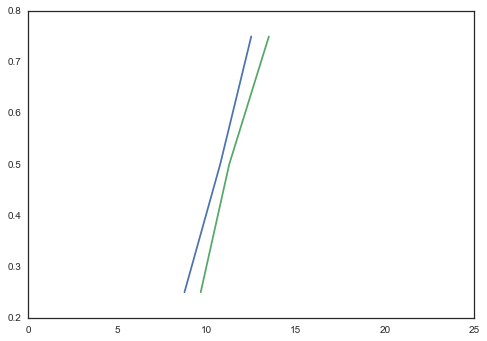

In [116]:
fig, ax = plt.subplots()
ax.plot(mquantiles(chdf[chdf.choice==0]['mn_ss'].values), [.25,.5,.75])
ax.plot(mquantiles(chdf[chdf.choice==1]['mn_ss'].values), [.25,.5,.75])
ax.set_xlim(0, 25)
plt.show()

# Predictions for competition dataset

In [10]:
technion.load_data('comp')
problems_comp = {(gid-1): technion.get_options(gid) for gid in technion.problems}
problems_comp_srt = technion.problems_srt - 1

data = pd.read_csv('data/tpt/tpt_data_comp.csv', index_col=0)
data['group'] = 0
data['problem'] = data['problem'] - 1

In [11]:
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems_comp,
          stoprule=stoprule)

pred = predict_from_result(m, problems_comp, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

#m = CHASEModel(drift='cpt', startdist='laplace', problems=problems_comp)
#pred = predict_from_result(m, problems_comp, data, SIM_ID, FIXED, fitting=fitting, 
#                           outdir=OUTDIR)

cp['tpt_comp'] = np.array([data[data.problem==i].choice.mean() for i in problems_comp_srt])
bf_cp['tpt_comp'] = np.array([pred[pred.problem==i].cp.mean() for i in problems_comp_srt])

quant['tpt_comp'] = mquantiles(data.samplesize)
bf_quant['tpt_comp'] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values #+ 2

print quant['tpt_comp']
print bf_quant['tpt_comp']

[  6.  11.  20.]
[  4.   8.  15.]


In [12]:
problems_comp_srt_cp = np.array((problems_comp_srt[:20][cp['tpt_comp'][:20].argsort()],
          problems_comp_srt[20:40][cp['tpt_comp'][20:40].argsort()],
          problems_comp_srt[40:][cp['tpt_comp'][40:].argsort()])).ravel()

cp_asc['tpt_comp'] = np.array([data[data.problem==i].choice.mean() for i in problems_comp_srt_cp])
bf_cp_asc['tpt_comp'] = pred.groupby('problem').apply(lambda d: d.cp.mean()).loc[problems_comp_srt_cp].values

In [13]:
observed = cp['tpt_comp']
predicted = bf_cp['tpt_comp']

pagree = np.sum(map(pmatch, zip(observed, predicted))) / float(len(observed))
tmp = filter(lambda pair: pair[0] != 0.5, zip(observed, predicted))
pagree_corr = np.sum(map(pmatch, tmp)) / float(len(tmp))

msd = np.round(np.mean((observed - predicted) ** 2), 4)
rcorr = np.round(pearsonr(observed, predicted)[0], 4)

tot_ss = np.sum((observed - np.mean(observed)) ** 2)
res_ss = np.sum((observed - predicted) ** 2)
r_sq = 1 - (res_ss / tot_ss)

print 'p(agree):\t', pagree
print 'p(agree)2:\t', pagree_corr
print 'r:\t\t', rcorr
print 'msd:\t\t', msd
print 'R2:\t\t', r_sq

p(agree):	0.9
p(agree)2:	0.928571428571
r:		0.655
msd:		0.0245
R2:		0.398429742209


# Combine results

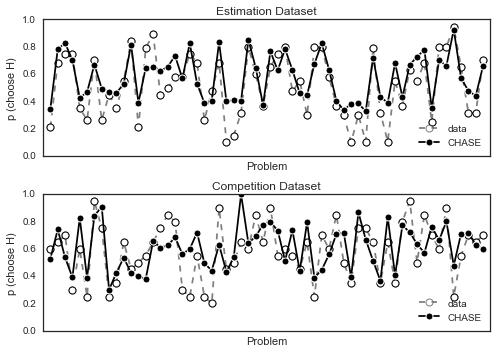

In [15]:
labels = ['Estimation Dataset', 'Competition Dataset']
col = ['black', 'black']

fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for i, study in enumerate(['tpt_est', 'tpt_comp']):
    axi = ax[i]
    axi.plot(range(1, 61), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 61), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 61), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 61)
    axi.set_xticks([])
    axi.set_xlabel('Problem')
    axi.set_ylabel('p (choose H)')
    axi.set_title(labels[i])
    axi.legend(loc='lower right')
plt.tight_layout()
plt.show()
#fig.savefig(FIGDEST + 'tpt_choiceprop.pdf', bbox_inches='tight')

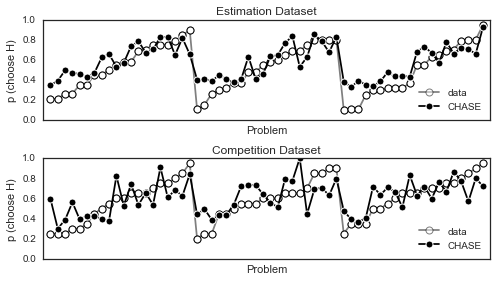

In [16]:
labels = ['Estimation Dataset', 'Competition Dataset']
col = ['black', 'black']

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
for i, study in enumerate(['tpt_est', 'tpt_comp']):
    axi = ax[i]
    axi.plot(range(1, 61), cp_asc[study], '-o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 61), cp_asc[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 61), bf_cp_asc[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 61)
    axi.set_xticks([])
    axi.set_xlabel('Problem')
    axi.set_ylabel('p (choose H)')
    axi.set_title(labels[i])
    axi.legend(loc='lower right')
    

plt.tight_layout()
plt.show()
fig.savefig('%s/tpt_choiceprop_asc.pdf' % FIGDEST, bbox_inches='tight')

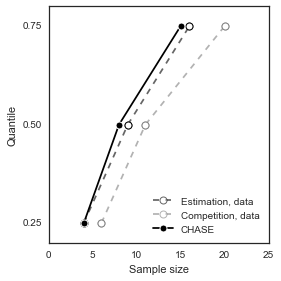

In [17]:
labels = ['Estimation', 'Competition']
col = ['black', 'gray']


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

axi = ax
for i, study in enumerate(['tpt_est', 'tpt_comp']):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    if i==1:
        axi.plot(bf_quant[study], [.25, .5, .75], '-o', color='black', 
                 markerfacecolor='black', markeredgecolor='white',
                 markeredgewidth=1, label='CHASE')

axi.set_xlim(0, 25)
axi.legend(loc='lower right')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])

plt.tight_layout()
plt.show()
fig.savefig('%s/tpt_quantiles.pdf' % FIGDEST, bbox_inches='tight')